#  **Introduction**
In this notebook, we will work on processing and analyzing the dataset that we all collaborate to collect, containing news in Arabic. The goal is to clean the data and prepare it for deeper analysis then to train our models.

##  **Fake News Detection Project Pipeline**

This project follows a structured pipeline to detect fake news in Arabic texts using machine learning models. The full workflow consists of the following stages:

###  Pipeline Overview:

1. **Load Dataset**  
   Load the news articles dataset from a CSV file.

2. **Preprocess Text**  
   Clean the Arabic text using a custom `clean_arabic_text()` function (removing punctuation, links, tashkeel, etc.).

3. **Feature Extraction**  
   Convert cleaned text into numerical features using **TF-IDF vectorization**.

4. **Train Models**  
   Train multiple classifiers including **BERT**, **SVC**, **Random Forest**, **Logistic Regression**, and **XGBoost**.

5. **Evaluate Models**  
   Evaluate models using **ROC Curve**, **Precision-Recall Curve**, **AUC**, and other metrics.

6. **Save Model & Vectorizer**  
   Save the best-performing model and vectorizer using `pickle` for later use.

7. **Prediction on New Text**  
   Load the saved model/vectorizer and make predictions on unseen text samples.

8. **Display Results**  
   Display the predicted label ("Real" or "Fake") along with a confidence score.

---

###  **Pipeline Diagram:**

fake_news_pipeline.svg


## **Installing and Importing necessary libraries and packages**

In [ ]:
!pip install arabic_reshaper python-bidi --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 11.6 MB/s eta 0:00:00


In [ ]:
!pip install python-bidi
!pip install wordcloud

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import arabic_reshaper
from bidi.algorithm import get_display

# **1. Data Loading**

### **→ Loading the Data File**
We start by loading the data from a CSV file titled "merged_cleaned.csv". This file contains news in Arabic with columns such as title, content, date, platform, and label (real or fake).

In [ ]:
data = pd.read_csv("merged_cleaned.csv")
data.head()

,Id,date,platform,title,News content,Label
0,1,2023-01-11 00:00:00,Aljazeera,الضفة الغربية.. الاحتلال يهدم 17 منزلا تاريخيا...,هدمت قوات الاحتلال الإسرائيلي -اليوم الأربعاء-...,real
1,2,2023-01-11 00:00:00,Aljazeera,مظاهرات بمدن أوروبية تضامنا مع غزة وحشود أمام ...,خرجت مظاهرات في عدد من المدن الأوروبية مساء ال...,real
2,3,2023-01-11 00:00:00,Aljazeera,شهداء في جنين وطولكرم وإضراب عام بالضفة الغربي...,استشهد 4 فلسطينيين واعتقل عشرات آخرون -اليوم ا...,real
3,4,2023-02-11 00:00:00,Aljazeera,أبو عبيدة: خسائر العدو أكبر بكثير مما يعلن وسن...,أكد الناطق باسمكتائب الشهيد عز الدين القسام-ال...,real
4,5,2023-03-11 00:00:00,Aljazeera,9 شهداء بالضفة والاحتلال يشن حملة اعتقالات,استشهد 9 فلسطينيين في مواجهات اندلعت مع قوات ا...,real


### **→ Checking for Missing Values**
We check for missing values in the "News content" column to ensure data quality before processing.

In [ ]:
num_missing_titles = data['News content'].isna().sum()
print(num_missing_titles)

0


# **2. Exploratory Data Analysis**



### **→ Univariate Analysis**
We explore the distribution of individual variables such as *labels*, *years*, *months*, and *platforms*

In [ ]:
# Dealing eith Arabic text
def reshape_arabic(text):
    return get_display(arabic_reshaper.reshape(str(text)))

In [ ]:
data['Arabic_Label'] = data['Label'].map({"fake": reshape_arabic('مزيف'), "real": reshape_arabic('حقيقي')})

#### **1. Label Distribution**
We analyze the distribution of news between "real" and "fake" using a bar chart.

In [ ]:
data['Label'].value_counts()

/tmp/ipython-input-8-368140946.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Arabic_Label', data=data, palette='hls')


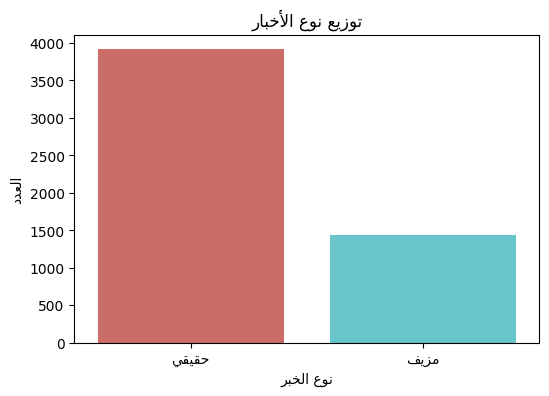

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Arabic_Label', data=data, palette='hls')
plt.title(reshape_arabic("توزيع نوع الأخبار"))
plt.xlabel(reshape_arabic("نوع الخبر"))
plt.ylabel(reshape_arabic("العدد"))
plt.xticks(rotation=0)
plt.show()

**The bar chart shows that there are more real news articles compared to fake ones, indicating an imbalance in the labels.**

#### **2. Year Distribution**
We explore the distribution of news across years.

In [ ]:
year = pd.to_datetime(data['date']).dt.year
year_grouped = year.apply(lambda x: '≤2022' if x <= 2022 else str(x))
order = ['≤2022', '2023', '2024', '2025']
year_grouped = pd.Categorical(year_grouped, categories=order, ordered=True)
year_counts = year_grouped.value_counts().sort_index()
year_counts

,count
≤2022,17
2023,1292
2024,3094
2025,949


/tmp/ipython-input-10-4265389522.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=year_grouped, palette='Set1')


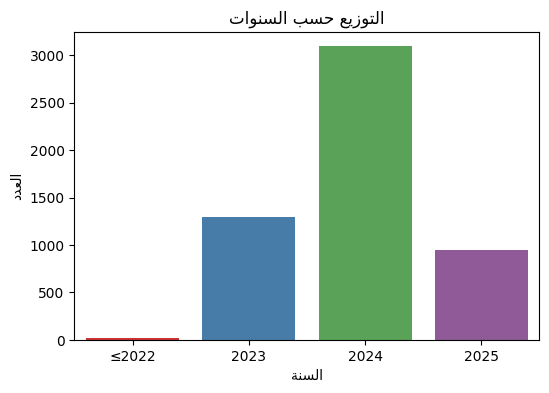

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=year_grouped, palette='Set1')
plt.title(reshape_arabic('التوزيع حسب السنوات'))
plt.xlabel(reshape_arabic('السنة'))
plt.ylabel(reshape_arabic('العدد'))
plt.xticks(rotation=0)
plt.show()

**The chart shows that most news articles are from a specific year (e.g., 2024), which may reflect increased data collection during that period.**

#### **3. Month Distribution**
We analyze the distribution of news across months.

In [ ]:
month = pd.to_datetime(data['date']).dt.month
month_order = [str(i) for i in range(1, 13)]
month_grouped = pd.Categorical(month.astype(str), categories=month_order, ordered=True)


/tmp/ipython-input-12-2288596518.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=month_grouped, palette='Set2')


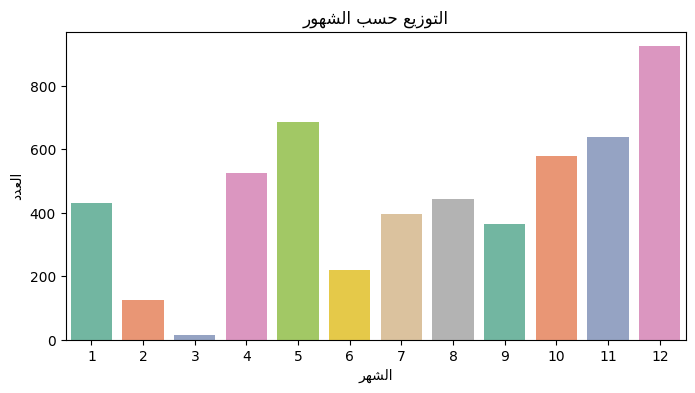

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x=month_grouped, palette='Set2')
plt.title(reshape_arabic('التوزيع حسب الشهور'))
plt.xlabel(reshape_arabic('الشهر'))
plt.ylabel(reshape_arabic('العدد'))
plt.xticks(rotation=0)
plt.show()

**The chart illustrates the distribution of news across months, helping to identify any seasonal patterns.**

#### **4. Platform Distribution**
We explore the distribution of news across platforms.

In [ ]:
platform_counts = data['platform'].value_counts()
top_platforms = platform_counts.nlargest(4).index
platform_grouped = data['platform'].apply(lambda x: x if x in top_platforms else 'Others')
order = list(top_platforms) + ['Others']
platform_grouped.value_counts()

,count
platform,
Aljazeera,3422
Misbar,1426
Tibyan,247
Others,193
X,64


/tmp/ipython-input-14-3220097531.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=platform_grouped,order=order ,palette='Set2')


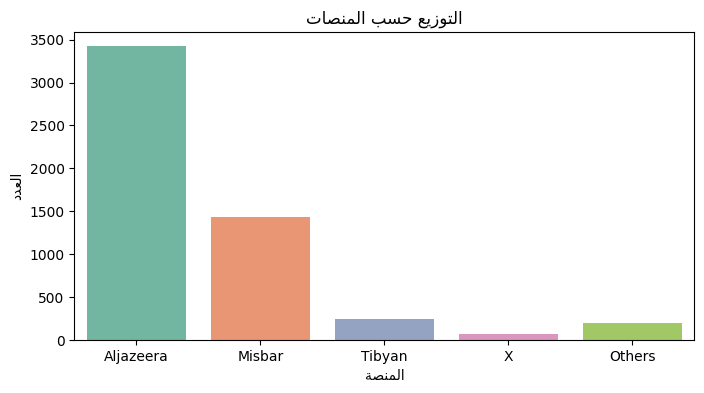

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x=platform_grouped,order=order ,palette='Set2')
plt.title(reshape_arabic('التوزيع حسب المنصات'))
plt.xlabel(reshape_arabic('المنصة'))
plt.ylabel(reshape_arabic('العدد'))
plt.xticks(rotation=0)
plt.show()

**The chart indicates that a particular platform (e.g., Aljazeera) dominates the dataset, which may influence the analysis of labels.**

### **→ Bivariate Analysis**
We examine the relationships between variables to understand their interactions.

#### **1.Relationship between Platform and News Label**
We analyze how real and fake news are distributed across platforms.

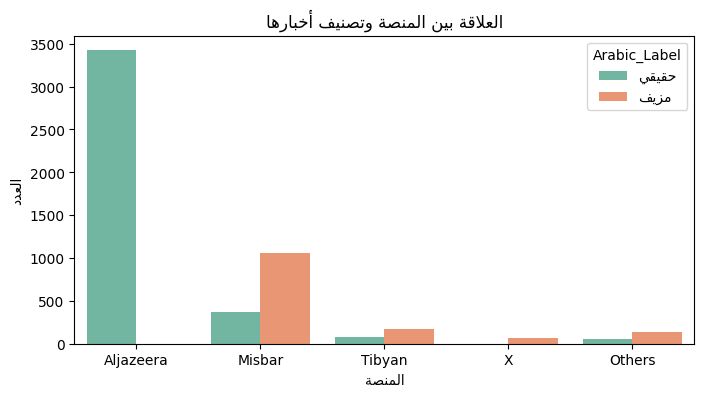

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x=platform_grouped,order=order, hue='Arabic_Label', data=data, palette='Set2')
plt.title(reshape_arabic('العلاقة بين المنصة وتصنيف أخبارها'))
plt.xlabel(reshape_arabic('المنصة'))
plt.ylabel(reshape_arabic('العدد'))
plt.show()

**The chart shows that some platforms have a higher proportion of fake news, indicating differences in content quality.**

#### **2. Relationship between Year and News Label**
We examine the distribution of real and fake news across years.

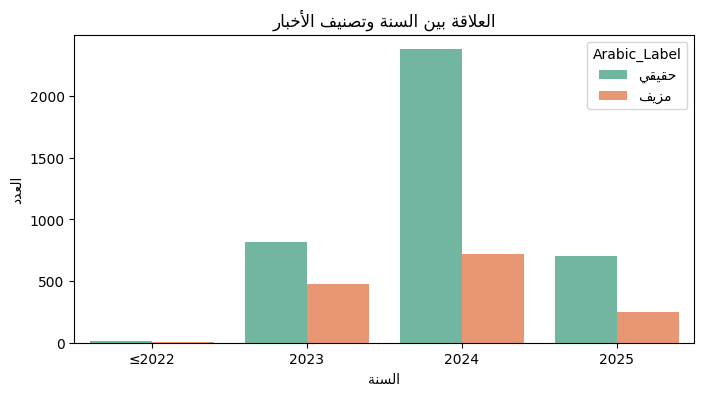

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x=year_grouped,  hue='Arabic_Label', data=data, palette='Set2')
plt.title(reshape_arabic('العلاقة بين السنة وتصنيف الأخبار'))
plt.xlabel(reshape_arabic('السنة'))
plt.ylabel(reshape_arabic('العدد'))
plt.show()

**The chart reveals temporal patterns in the distribution of real and fake news, possibly related to specific events.**

#### **3. Relationship between Month and News Label**
We analyze the distribution of news by months and labels.

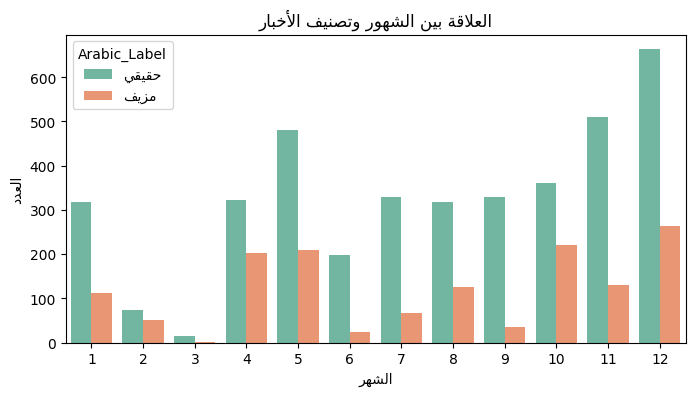

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x=month_grouped,  hue='Arabic_Label', data=data, palette='Set2')
plt.title(reshape_arabic('العلاقة بين الشهور وتصنيف الأخبار'))
plt.xlabel(reshape_arabic('الشهر'))
plt.ylabel(reshape_arabic('العدد'))
plt.show()

**The chart indicates whether there are seasonal patterns in fake or real news.**

# **3. Data Processing**

### **→ Merging Title with News Content**
We merge the title and news content into a single field called *full_news* to facilitate text processing later.

In [ ]:
processedData= pd.DataFrame()

In [ ]:
processedData['full_news'] = data['title'] + " " + data['News content']

### **→ Converting Labels to Numbers**
We convert the textual labels ("real", "fake") to numerical values (1, 0) to make them suitable for machine learning models.

In [ ]:
processedData['Label'] = data['Label'].map({'real': 1, 'fake': 0})
processedData.head()

,full_news,Label
0,الضفة الغربية.. الاحتلال يهدم 17 منزلا تاريخيا...,1
1,مظاهرات بمدن أوروبية تضامنا مع غزة وحشود أمام ...,1
2,شهداء في جنين وطولكرم وإضراب عام بالضفة الغربي...,1
3,أبو عبيدة: خسائر العدو أكبر بكثير مما يعلن وسن...,1
4,9 شهداء بالضفة والاحتلال يشن حملة اعتقالات است...,1


### **→ Text Cleaning**
We clean the texts by removing links, HTML tags, emojis, and Arabic diacritics, while keeping only Arabic texts.

In [ ]:
import re

def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Remove URLs
    text = re.sub(r'http\S+|www.\S+|pic\.twitter\.com/\S+', '', text)


    # Remove HTML
    text = re.sub(r'<.*?>', '', text)


    # Remove Emojies
    text = remove_emojis(text)


    # Remove Arabic diacritics
    text = re.sub(r'[\u064B-\u0652]', '', text)


    # # Remove punctuation (Arabic and general)
    # text = re.sub(r'[ـ،؛؟!:\.\,\(\)\[\]\{\}"\'«»\-_~…]', '', text)


    text = re.sub(r'[إأآا]', 'ا', text)

    lines = text.split('\n')


    cleaned_lines = []
    for line in lines:
        # Remove line if it not arabic
        if re.fullmatch(r'[^\u0600-\u06FF]+', line.strip()):
            continue


        # Keep Arabic lines
        line = re.sub(r'[^\u0600-\u06FF\s]', '', line)


        # Remove empty lines
        if line.strip():
            cleaned_lines.append(line.strip())

    # Join the cleaned lines
    return '\n'.join(cleaned_lines)


In [ ]:
processedData['full_news'] = processedData['full_news'].apply(clean_text)

**Why Cleaning?**

Removing links, HTML tags, emojis, and diacritics is necessary because they do not contribute to the meaning of the text and can interfere with natural language processing algorithms.

### **→ Removing Stop Words**
We remove common stop words like "و", "في", "على" to reduce noise and focus on meaningful words.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('arabic'))

In [ ]:
processedData['full_news_no_stopwords'] = processedData['full_news'].apply(
    lambda text: ' '.join([word for word in text.split() if word not in stop_words])
)

In [ ]:
import requests

url = "https://raw.githubusercontent.com/mohataher/arabic-stop-words/master/list.txt"
response = requests.get(url)

with open("list.txt", "w", encoding="utf-8") as f:
    f.write(response.text)

with open("list.txt", encoding="utf-8") as f:
    arabic_stopwords = set(f.read().splitlines())



In [ ]:
processedData['full_news_no_stopwords'] = processedData['full_news_no_stopwords'].apply(
    lambda text: ' '.join([word for word in text.split() if word not in arabic_stopwords])
)

In [ ]:
processedData.to_csv('ProcessedData_StopwordsStep.csv', index=False, encoding='utf-8-sig')


In [ ]:
processedData.head()

,full_news,Label,full_news_no_stopwords
0,الضفة الغربية الاحتلال يهدم منزلا تاريخيا ومس...,1,الضفة الغربية الاحتلال يهدم منزلا تاريخيا ومسي...
1,مظاهرات بمدن اوروبية تضامنا مع غزة وحشود امام ...,1,مظاهرات بمدن اوروبية تضامنا غزة وحشود داونينغ ...
2,شهداء في جنين وطولكرم واضراب عام بالضفة الغربي...,1,شهداء جنين وطولكرم واضراب بالضفة الغربية تنديد...
3,ابو عبيدة خسائر العدو اكبر بكثير مما يعلن وسنج...,1,ابو عبيدة خسائر العدو اكبر بكثير يعلن وسنجعل غ...
4,شهداء بالضفة والاحتلال يشن حملة اعتقالات استشه...,1,شهداء بالضفة والاحتلال يشن حملة اعتقالات استشه...


#### **Words Cloud example before removing stop words & after removing stop words**

In [ ]:
from collections import Counter
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud, ImageColorGenerator
from IPython.display import Image, display

In [ ]:
from IPython.display import Image, display, Markdown

In [ ]:
font_file = '/content/arial.ttf'

In [ ]:
text = " ".join(arabic_reshaper.reshape(t) for t in processedData['full_news'].dropna())

# create and display the wordcloud
wordcloud = WordCloud(font_path=font_file, width = 3500, height = 2000, random_state=1,
                      background_color='white', colormap='Set2', collocations=False,).generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("with_stops.png", dpi=300, bbox_inches='tight')
plt.close()

###  Words Cloud before removing stop words

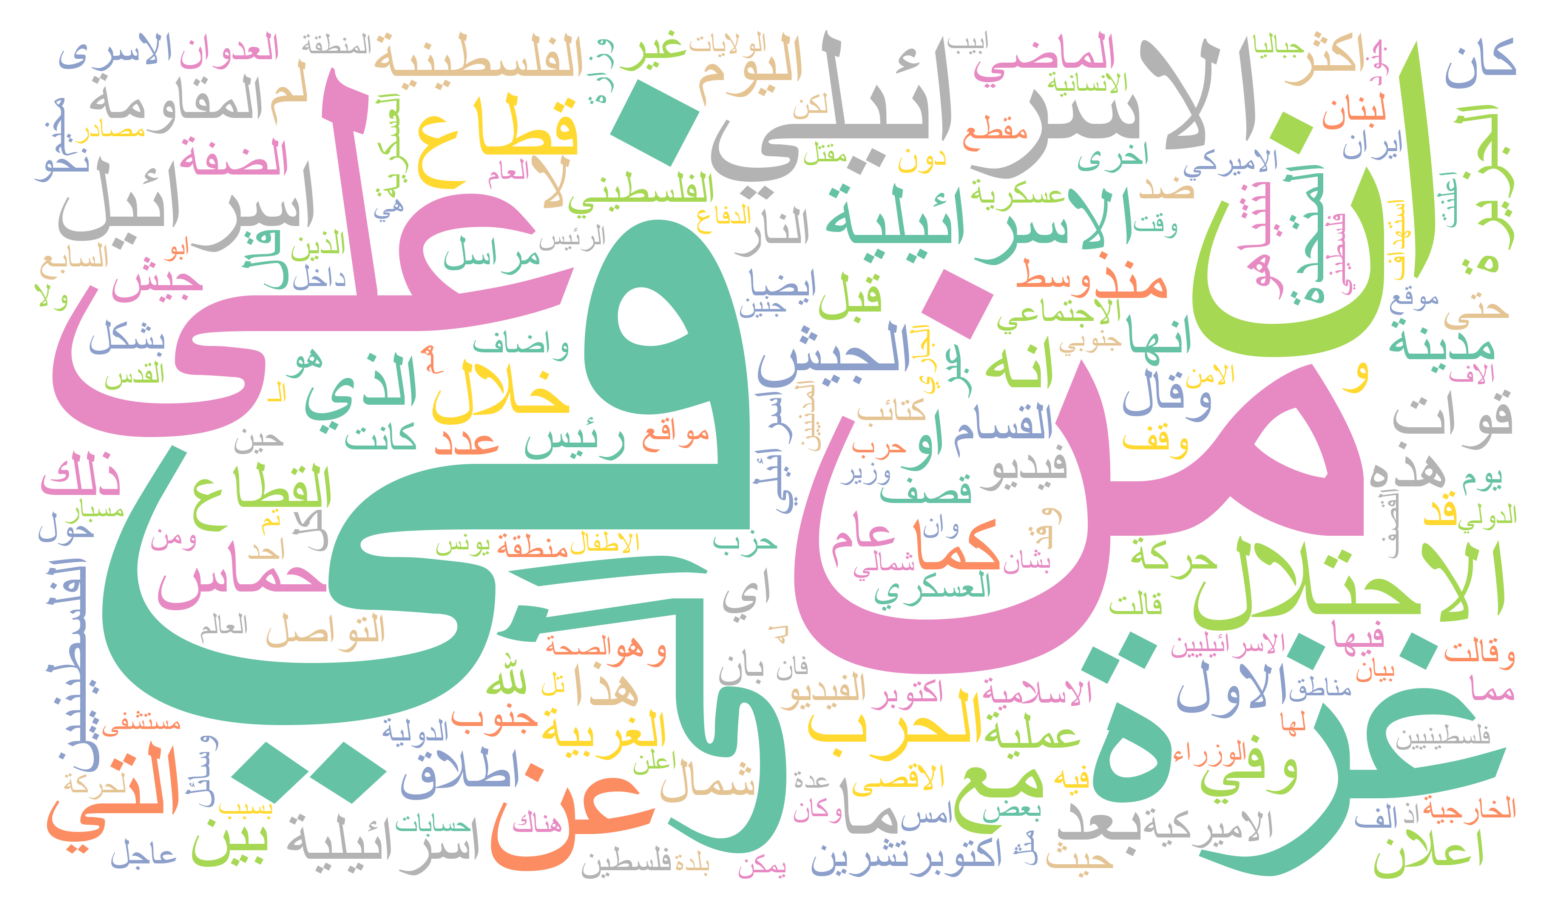

In [ ]:
display(Markdown("###  Words Cloud before removing stop words"))
display(Image(filename='with_stops.png',width=600, height=600))

In [ ]:
text = " ".join(arabic_reshaper.reshape(t) for t in processedData['full_news_no_stopwords'].dropna())

# create and display the wordcloud
wordcloud = WordCloud(font_path=font_file, width = 3500, height = 2000, random_state=1,
                      background_color='white', colormap='Set2', collocations=False,).generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("without_stops.png", dpi=300, bbox_inches='tight')
plt.close()

###  Words Cloud after removing stop words

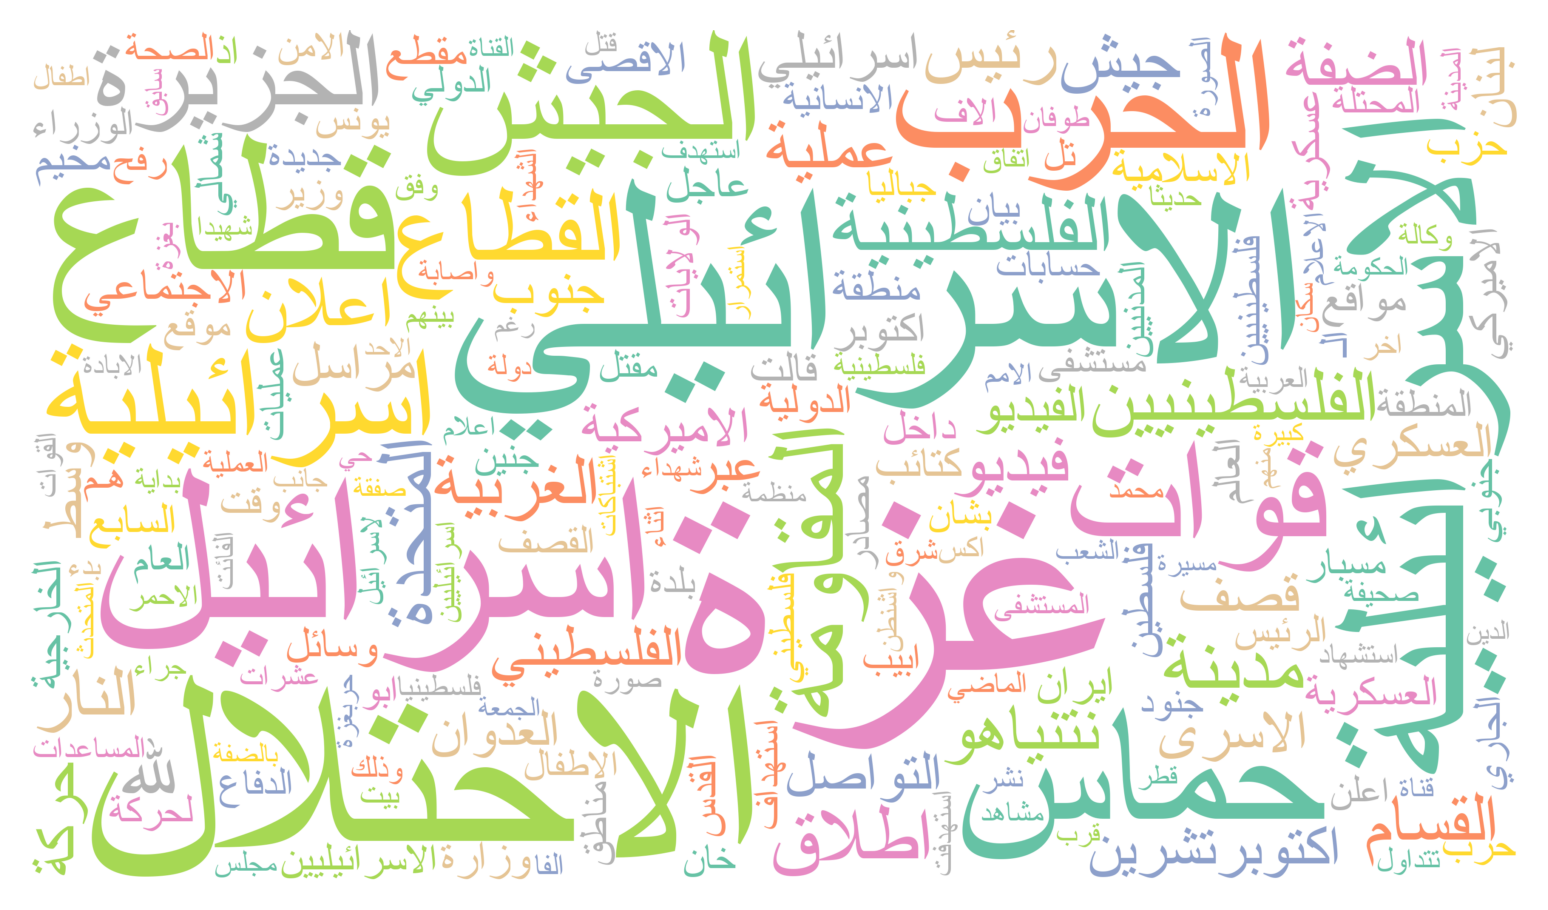

In [ ]:
display(Markdown("###  Words Cloud after removing stop words"))

display(Image(filename='without_stops.png',width=600, height=600))

In [ ]:
from IPython.display import display, Markdown
test = 800

original_title = data.iloc[test]['title']
original_content = data.iloc[test]['News content']

cleaned = processedData.iloc[test]['full_news']
cleaned_no_stopwords = processedData.iloc[test]['full_news_no_stopwords']

display(Markdown("##  Original News Content"))
display(Markdown(f"**Title:** {original_title}"))
display(Markdown(f"**Length:** {len(original_title + ' ' + original_content)} characters"))
display(Markdown(original_content))

display(Markdown("##  Cleaned News"))
display(Markdown(f"**Length:** {len(cleaned)} characters"))
display(Markdown(cleaned))

display(Markdown("##  Cleaned News (No Stopwords)"))
display(Markdown(f"**Length:** {len(cleaned_no_stopwords)} characters"))
display(Markdown(cleaned_no_stopwords))


##  Original News Content

**Title:** "لا تتركونا نشيخ".. القسام تنشر رسالة من أسرى إسرائيليين لحكومتهم

**Length:** 1172 characters

نشرت كتائب القسام -الجناح العسكري لحركة المقاومة الإسلامية (حماس)- مقطعا مرئيا يظهر فيه 3 أسرى إسرائيليين في قطاع غزة يطالبون قادتهم بعدم تركهم في الأسر و"ألا يشيخوا فيه".

وقال أحد الأسرى الإسرائيليين ويُدعى حاييم بري (79 عاما)، إنه من كيبوتس نير عوز، وموجود في الأسر برفقة مجموعة كبار في السن، مرضى بأمراض مزمنة، ويعانون ظروفا قاسية للغاية.

وأضاف "نحن جيل بنى الدولة (إسرائيل)، ونحن شاركنا في بناء الجيش، ولا أفهم لماذا نحن متروكون هنا؟"، قبل أن يكمل مناشدا على ما يبدو رئيس الوزراء الإسرائيلي بنيامين نتنياهو، بالقول "يجب عليك أن تفرج عنا بكل ثمن".

وتابع "نحن لا نريد أن نكون ضحايا لاستهدافات سلاح الجو، أفرج عنا من دون أي شرط، ولا تتركونا نشيخ".

ونجحت وساطة قطرية في التوصل إلى هدنة إنسانية مؤقتة استمرت أسبوعا، وتم خلالها الإفراج عن محتجزين إسرائيليين في قطاع غزة، مقابل إطلاق سراح أسرى فلسطينيين من النساء والأطفال وفق معادلة (1 مقابل 3)، قبل أن تنهار الهدنة مطلع ديسمبر/كانون الأول الجاري.

وتتصاعد المظاهرات في تل أبيب المطالبة بضرورة إبرام صفقة تبادل جديدة خاصة بعد مقتل 3 أسرى إسرائيليين في غزة على يد قوات الاحتلال، وهو ما أثار موجة غضب عارمة وألقت مزيدا من الضغوط على حكومة نتنياهو اليمينية.

##  Cleaned News

**Length:** 1131 characters

لا تتركونا نشيخ القسام تنشر رسالة من اسرى اسرائيليين لحكومتهم نشرت كتائب القسام الجناح العسكري لحركة المقاومة الاسلامية حماس مقطعا مرئيا يظهر فيه  اسرى اسرائيليين في قطاع غزة يطالبون قادتهم بعدم تركهم في الاسر والا يشيخوا فيه
وقال احد الاسرى الاسرائيليين ويدعى حاييم بري  عاما، انه من كيبوتس نير عوز، وموجود في الاسر برفقة مجموعة كبار في السن، مرضى بامراض مزمنة، ويعانون ظروفا قاسية للغاية
واضاف نحن جيل بنى الدولة اسرائيل، ونحن شاركنا في بناء الجيش، ولا افهم لماذا نحن متروكون هنا؟، قبل ان يكمل مناشدا على ما يبدو رئيس الوزراء الاسرائيلي بنيامين نتنياهو، بالقول يجب عليك ان تفرج عنا بكل ثمن
وتابع نحن لا نريد ان نكون ضحايا لاستهدافات سلاح الجو، افرج عنا من دون اي شرط، ولا تتركونا نشيخ
ونجحت وساطة قطرية في التوصل الى هدنة انسانية مؤقتة استمرت اسبوعا، وتم خلالها الافراج عن محتجزين اسرائيليين في قطاع غزة، مقابل اطلاق سراح اسرى فلسطينيين من النساء والاطفال وفق معادلة  مقابل ، قبل ان تنهار الهدنة مطلع ديسمبركانون الاول الجاري
وتتصاعد المظاهرات في تل ابيب المطالبة بضرورة ابرام صفقة تبادل جديدة خاصة بعد مقتل  اسرى اسرائيليين في غزة على يد قوات الاحتلال، وهو ما اثار موجة غضب عارمة والقت مزيدا من الضغوط على حكومة نتنياهو اليمينية

##  Cleaned News (No Stopwords)

**Length:** 936 characters

تتركونا نشيخ القسام تنشر رسالة اسرى اسرائيليين لحكومتهم نشرت كتائب القسام الجناح العسكري لحركة المقاومة الاسلامية حماس مقطعا مرئيا يظهر اسرى اسرائيليين قطاع غزة يطالبون قادتهم بعدم تركهم الاسر والا يشيخوا الاسرى الاسرائيليين ويدعى حاييم بري عاما، كيبوتس نير عوز، وموجود الاسر برفقة مجموعة كبار السن، مرضى بامراض مزمنة، ويعانون ظروفا قاسية للغاية جيل بنى الدولة اسرائيل، ونحن شاركنا بناء الجيش، افهم متروكون هنا؟، يكمل مناشدا يبدو رئيس الوزراء الاسرائيلي بنيامين نتنياهو، بالقول يجب تفرج عنا بكل ثمن وتابع نريد نكون ضحايا لاستهدافات سلاح الجو، افرج عنا شرط، تتركونا نشيخ ونجحت وساطة قطرية التوصل هدنة انسانية مؤقتة استمرت اسبوعا، وتم خلالها الافراج محتجزين اسرائيليين قطاع غزة، اطلاق سراح اسرى فلسطينيين النساء والاطفال وفق معادلة تنهار الهدنة مطلع ديسمبركانون الجاري وتتصاعد المظاهرات تل ابيب المطالبة بضرورة ابرام صفقة تبادل جديدة مقتل اسرى اسرائيليين غزة يد قوات الاحتلال، اثار موجة غضب عارمة والقت مزيدا الضغوط حكومة نتنياهو اليمينية

### **→ Removing NERs**

In [ ]:
#!pip install stanza --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#import stanza
#stanza.download('ar')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: ar (Arabic) ...


INFO:stanza:Downloaded file to /root/stanza_resources/ar/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


In [ ]:
#import pandas as pd
#import re
#import pandas as pd
#processedData = pd.read_csv("ProcessedData_StopwordsStep.csv")
#processedData.head()

,full_news,Label,full_news_no_stopwords
0,الضفة الغربية الاحتلال يهدم منزلا تاريخيا ومس...,1,الضفة الغربية الاحتلال يهدم منزلا تاريخيا ومسي...
1,مظاهرات بمدن اوروبية تضامنا مع غزة وحشود امام ...,1,مظاهرات بمدن اوروبية تضامنا غزة وحشود داونينغ ...
2,شهداء في جنين وطولكرم واضراب عام بالضفة الغربي...,1,شهداء جنين وطولكرم واضراب بالضفة الغربية تنديد...
3,ابو عبيدة خسائر العدو اكبر بكثير مما يعلن وسنج...,1,ابو عبيدة خسائر العدو اكبر بكثير يعلن وسنجعل غ...
4,شهداء بالضفة والاحتلال يشن حملة اعتقالات استشه...,1,شهداء بالضفة والاحتلال يشن حملة اعتقالات استشه...


In [ ]:
#nlp = stanza.Pipeline(lang='ar',processors='tokenize,ner')

#def remove_and_return_named_entities(text):
#    doc = nlp(text)
#    named_entities = [(ent.text, ent.type) for ent in doc.ents]

#    for ent_text, _ in named_entities:
#        text = text.replace(ent_text, '')

#    return text.strip(), named_entities


INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: ar (Arabic):
| Processor | Package      |
----------------------------
| tokenize  | padt         |
| mwt       | padt         |
| ner       | aqmar_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [ ]:
#processedData['full_news_no_ner'], entities = processedData['full_news_no_stopwords'].apply(remove_and_return_named_entities)

In [ ]:
#nlp = stanza.Pipeline(lang='ar',processors='tokenize,ner')

#def remove_named_entities_stanza(text):
 #    doc = nlp(text)
  #   ents = [ent.text for ent in doc.ents]

   #  for ent in ents:
    #     text = text.replace(ent, '')

     #return text.strip()

In [ ]:
# processedData['full_news_no_ner'] = processedData['full_news_no_stopwords'].apply(remove_named_entities_stanza)



In [ ]:
NERremoved = pd.read_csv('processedDataNoStopwordsNoNERs.csv')
NERremoved


,full_news,Label,full_news_no_stopwords,full_news_no_ner
0,الضفة الغربية الاحتلال يهدم منزلا تاريخيا ومس...,1,الضفة الغربية الاحتلال يهدم منزلا تاريخيا ومسي...,الضفة الغربية الاحتلال يهدم منزلا تاريخيا ومسي...
1,مظاهرات بمدن اوروبية تضامنا مع غزة وحشود امام ...,1,مظاهرات بمدن اوروبية تضامنا غزة وحشود داونينغ ...,مظاهرات بمدن تضامنا وحشود خرجت مظاهرات المد...
2,شهداء في جنين وطولكرم واضراب عام بالضفة الغربي...,1,شهداء جنين وطولكرم واضراب بالضفة الغربية تنديد...,شهداء واضراب تنديدا بمجازر استشهد واعتقل ...
3,ابو عبيدة خسائر العدو اكبر بكثير مما يعلن وسنج...,1,ابو عبيدة خسائر العدو اكبر بكثير يعلن وسنجعل غ...,خسائر العدو اكبر بكثير يعلن وسنجعل لعنة التار...
4,شهداء بالضفة والاحتلال يشن حملة اعتقالات استشه...,1,شهداء بالضفة والاحتلال يشن حملة اعتقالات استشه...,شهداء بالضفة والاحتلال يشن حملة اعتقالات استشه...
...,...,...,...,...
5346,الحرب على غزة مباشر المقاومة تكبد الاحتلال خسا...,1,الحرب غزة مباشر المقاومة تكبد الاحتلال خسائر ك...,الحرب مباشر المقاومة تكبد الاحتلال خسائر كبير...
5347,تصريح قديم لمقاتل من كتائب القسام حول اشتباكات...,0,تصريح قديم لمقاتل كتائب القسام اشتباكات قوات ا...,تصريح قديم لمقاتل اشتباكات الحرب الجارية تتد...
5348,الفيديو الذي يهدد فيه احمد موسى حماس قديم وليس...,0,الفيديو يهدد احمد موسى حماس قديم الحرب غزة تتد...,الفيديو يهدد قديم الحرب تتداول صفحات وحسابات...
5349,تدعم قطع الدعم عن الاونروا منظمات دولية تنشر ت...,1,تدعم قطع الدعم الاونروا منظمات دولية تنشر تقار...,تدعم قطع الدعم منظمات دولية تنشر تقارير دقيقة...


### **→ Lemmatization**

In [ ]:
# import stanza
# from tqdm import tqdm

# stanza.download('ar')
# nlp = stanza.Pipeline(lang='ar', processors='tokenize,mwt,pos,lemma')
# tqdm.pandas()

# def lemmatize_text(text):
#     try:
#         doc = nlp(text)
#         lemmas = [word.lemma for sent in doc.sentences for word in sent.words]
#         return ' '.join(lemmas)
#     except:
#         return ''

# processedDataNoStopwordsNoNERs['full_news_lemma'] = processedDataNoStopwordsNoNERs['full_news_no_ner'].progress_apply(lemmatize_text)
# processedDataNoStopwordsNoNERs.to_csv('processedDataLemma.csv', index=False, encoding='utf-8-sig')


In [ ]:
# import re

# def remove_diacritics(text):
#     arabic_diacritics = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
#     return re.sub(arabic_diacritics, '', text)

# processedDataNoStopwordsNoNERs['full_news_lemma_clean'] = processedDataNoStopwordsNoNERs['full_news_lemma'].astype(str).apply(remove_diacritics)


In [ ]:
import pandas as pd

In [ ]:
processedDataLemma = pd.read_csv("/content/drive/MyDrive/processedDataLemma.csv")

In [ ]:
processedDataLemma.head(2)


,full_news,Label,full_news_no_stopwords,full_news_no_ner,full_news_lemma,full_news_lemma_clean
0,الضفة الغربية الاحتلال يهدم منزلا تاريخيا ومس...,1,الضفة الغربية الاحتلال يهدم منزلا تاريخيا ومسي...,الضفة الغربية الاحتلال يهدم منزلا تاريخيا ومسي...,ضِفَّة غَربِيّ اِحتِلَال هَدَم مَنزِل تَارِيخِ...,ضفة غربي احتلال هدم منزل تاريخي و مسيرة ندد ب ...
1,مظاهرات بمدن اوروبية تضامنا مع غزة وحشود امام ...,1,مظاهرات بمدن اوروبية تضامنا غزة وحشود داونينغ ...,مظاهرات بمدن تضامنا وحشود خرجت مظاهرات المد...,مُظَاهَرَة بِ مَدِينَة أَضَام هُوَ وَ حَشد خَر...,مظاهرة ب مدينة أضام هو و حشد خرج مظاهرة مدينة ...


In [ ]:
from IPython.display import display, Markdown
test = 840


cleaned = processedDataLemma.iloc[test]['full_news']
cleaned_no_stopwords = processedDataLemma.iloc[test]['full_news_no_stopwords']
cleaned_no_ner = processedDataLemma.iloc[test]['full_news_no_ner']
full_news_lemma = processedDataLemma.iloc[test]['full_news_lemma']
full_news_lemma_clean = processedDataLemma.iloc[test]['full_news_lemma_clean']



display(Markdown("##  Cleaned News"))
display(Markdown(f"**Length:** {len(cleaned)} characters"))
display(Markdown(cleaned))

display(Markdown("##  Cleaned News (No Stopwords)"))
display(Markdown(f"**Length:** {len(cleaned_no_stopwords)} characters"))
display(Markdown(cleaned_no_stopwords))


display(Markdown("##  Cleaned News (No NERs)"))
display(Markdown(f"**Length:** {len(cleaned_no_ner)} characters"))
display(Markdown(cleaned_no_ner))


display(Markdown("##  Cleaned News (Lemma)"))
display(Markdown(f"**Length:** {len(full_news_lemma)} characters"))
display(Markdown(full_news_lemma))

display(Markdown("##  Cleaned News (Lemma No Diacritics )"))
display(Markdown(f"**Length:** {len(full_news_lemma_clean)} characters"))
display(Markdown(full_news_lemma_clean))



##  Cleaned News

**Length:** 1348 characters

بلومبيرغ تاييد بايدن بادنى مستوى له على الاطلاق نشر موقع بلومبيرغ الاخباري الاميركي نقلا عن استطلاع اجرته جامعة مونموث ان معدلات تاييد الرئيس الاميركي جو بايدن وصلت لادنى مستوياتها على الاطلاق، مدفوعة بالمخاوف بشان ارتفاع الاسعار والامن على الحدود بين الولايات المتحدة والمكسيك
وكشفت نتائج الاستطلاع ان  فقط يوافقون على اداء بايدن الوظيفي، بانخفاض من  في بداية رئاسته قبل نحو  سنوات
واثار انخفاض شعبية الرئيس الاميركي حفيظته حيث وجه كلمات صارمة لمساعديه، قائلا ان ارقامه في استطلاعات الراي منخفضة بشكل غير مقبول، وفق ما ذكرت صحيفة واشنطن بوست
وقالت الصحيفة ان حديث بايدن هذا جاء عندما اراد معرفة كيف يتصرف فريقه وحملته بشان انخفاض ارقامه في استطلاعات الراي
وكان استطلاع اجرته رويترزابسوس مطلع ديسمبركانون الاول الجاري اظهر ان شعبية بايدن اقتربت من ادنى مستوياتها خلال رئاسته هذا الشهر
واظهر الاستطلاع ان  من المشاركين يستحسنون اداء بايدن رئيسا، بزيادة هامشية على نسبة  حصل عليها الشهر الماضي، علما ان هامش الخطا في الاستطلاع بلغ نحو
واعتبر الاميركيون الاقتصاد والجريمة والهجرة اكبر المشكلات التي تواجه البلاد حسب ما اظهر الاستطلاع وهي جميع القضايا التي انتقد الرئيس السابق دونالد ترامب وغيره من الجمهوريين بايدن بشانها
اعلان
كما صنف  من المشاركين بالاستطلاع الاقتصاد على انه القضية الاولى، في حين اشار  الى الهجرة، و الى الجريمة
واستقر معدل القبول العام لبايدن عند اقل من  منذ اغسطساب ، وظل تصنيف هذا الشهر قريبا من ادنى مستوى في رئاسته، وهو  منتصف

##  Cleaned News (No Stopwords)

**Length:** 1088 characters

بلومبيرغ تاييد بايدن بادنى مستوى الاطلاق نشر موقع بلومبيرغ الاخباري الاميركي نقلا استطلاع اجرته جامعة مونموث معدلات تاييد الرئيس الاميركي جو بايدن وصلت لادنى مستوياتها الاطلاق، مدفوعة بالمخاوف بشان ارتفاع الاسعار والامن الحدود الولايات المتحدة والمكسيك وكشفت نتائج الاستطلاع يوافقون اداء بايدن الوظيفي، بانخفاض بداية رئاسته واثار انخفاض شعبية الرئيس الاميركي حفيظته وجه كلمات صارمة لمساعديه، قائلا ارقامه استطلاعات الراي منخفضة مقبول، وفق ذكرت صحيفة واشنطن بوست الصحيفة حديث بايدن جاء اراد معرفة يتصرف فريقه وحملته بشان انخفاض ارقامه استطلاعات الراي استطلاع اجرته رويترزابسوس مطلع ديسمبركانون الجاري اظهر شعبية بايدن اقتربت ادنى مستوياتها رئاسته الشهر واظهر الاستطلاع المشاركين يستحسنون اداء بايدن رئيسا، بزيادة هامشية نسبة حصل الشهر الماضي، علما هامش الخطا الاستطلاع بلغ واعتبر الاميركيون الاقتصاد والجريمة والهجرة اكبر المشكلات تواجه البلاد اظهر الاستطلاع القضايا انتقد الرئيس دونالد ترامب وغيره الجمهوريين بايدن بشانها اعلان صنف المشاركين بالاستطلاع الاقتصاد القضية الاولى، اشار الهجرة، الجريمة واستقر معدل القبول العام لبايدن اقل اغسطساب وظل تصنيف الشهر قريبا ادنى مستوى رئاسته، منتصف

##  Cleaned News (No NERs)

**Length:** 951 characters

بادنى مستوى الاطلاق نشر موقع  الاخباري الاميركي نقلا استطلاع اجرته  معدلات تاييد الرئيس الاميركي  وصلت لادنى مستوياتها الاطلاق، مدفوعة بالمخاوف بشان ارتفاع الاسعار والامن الحدود   وكشفت نتائج الاستطلاع يوافقون اداء  الوظيفي، بانخفاض بداية رئاسته واثار انخفاض شعبية الرئيس الاميركي حفيظته وجه كلمات صارمة لمساعديه، قائلا ارقامه استطلاعات الراي منخفضة مقبول، وفق ذكرت صحيفة  الصحيفة حديث  جاء اراد معرفة يتصرف فريقه وحملته بشان انخفاض ارقامه استطلاعات الراي استطلاع اجرته  مطلع ديسمبركانون الجاري اظهر شعبية  اقتربت ادنى مستوياتها رئاسته الشهر واظهر الاستطلاع المشاركين يستحسنون اداء  رئيسا، بزيادة هامشية نسبة حصل الشهر الماضي، علما هامش الخطا الاستطلاع بلغ واعتبر الاميركيون الاقتصاد والجريمة والهجرة اكبر المشكلات تواجه البلاد اظهر الاستطلاع القضايا انتقد الرئيس  وغيره الجمهوريين  بشانها اعلان صنف المشاركين بالاستطلاع الاقتصاد القضية الاولى، اشار الهجرة، الجريمة واستقر معدل القبول العام ل اقل اغسطساب وظل تصنيف الشهر قريبا ادنى مستوى رئاسته، منتصف

##  Cleaned News (Lemma)

**Length:** 1225 characters

بَادنِي مستوى إِطلَاق نَشَر مَوقِع إِخبَارِيّ أَمِيرِكِيّ نَقل اِستِطلَاع أَجرَى هُوَ مُعَدَّل تاييد رَئِيس أَمِيرِكِيّ وَصَل لِ أَدنَى مُستَوَى هُوَ إِطلَاق ، مَدفُوع بِ مَخَافَة بِ شَأن اِرتِفَاع سِعر وَ أَمن حَدّ وَ كَشَف نَتِيجَة اِستِطلَاع وَافَق أَدَاء وَظِيفِيّ ، بِ اِنخِفَاض بِدَايَة رِئَاسَة هُوَ وَ أَثَار اِنخِفَاض شَعبِيَّة رَئِيس أَمِيرِكِيّ حَفِيظَة هُوَ وَجَّه كَلِمَة صَارِم لِ مُسَاعِد هُوَ ، قَائِل رَقم هُوَ اِستِطلَاع رَأي مُنخَفِض مَقبُول ، وَ فَقّ ذَكَر صَحِيفَة صَحِيفَة حَدِيث جَاء أَرَاد مَعرِفَة تَصَرَّف فَرِيق هُوَ وَ حَملَة هُوَ بِ شَأن اِنخِفَاض رَقم هُوَ اِستِطلَاع رَأي اِستِطلَاع أَجرَى هُوَ مَطلَع دِيسمبِركَان الجاري أَظهَر شَعبِيَّة اِقتَرَب أَدنَى مُستَوَى هُوَ رِئَاسَة هُوَ شَهر وَ أَظهَر اِستِطلَاع مُشَارِك اِستَحسَن أَدَاء رَئِيس ، بِ زِيَادَة هَامِشِيّ نِسبَة حَصَل شَهر مَاضِي ، عِلم هَامِش خَطّ اِستِطلَاع بَلَغ وَ اِعتَبَر أَمِيرِكِيّ اِقتِصَاد وَ جَرِيمَة وَ هِجرَة أَكبَر مُشكِلَة وَاجَه بَلَد أَظهَر اِستِطلَاع قَضِيَّة اِنتَقَد رَئِيس وَ غَير هُوَ جُمهُورِيّ بشان هُوَ إِعلَان صِنف مُشَارِك بِ اِستِطلَاع اِقتِصَاد قَضِيَّة أَوَّل ، أَشَار هِجرَة ، جَرِيمَة وَ اِستَقَرّ مُعَدَّل قُبُول عَامّ لِ أَقَلّ اغسطساب وَظَل تَصنِيف شَهر قَرِيب أَدنَى مستوى رِئَاسَة هُوَ ، مُنتَصَف

##  Cleaned News (Lemma No Diacritics )

**Length:** 850 characters

بادني مستوى إطلاق نشر موقع إخباري أميركي نقل استطلاع أجرى هو معدل تاييد رئيس أميركي وصل ل أدنى مستوى هو إطلاق ، مدفوع ب مخافة ب شأن ارتفاع سعر و أمن حد و كشف نتيجة استطلاع وافق أداء وظيفي ، ب انخفاض بداية رئاسة هو و أثار انخفاض شعبية رئيس أميركي حفيظة هو وجه كلمة صارم ل مساعد هو ، قائل رقم هو استطلاع رأي منخفض مقبول ، و فق ذكر صحيفة صحيفة حديث جاء أراد معرفة تصرف فريق هو و حملة هو ب شأن انخفاض رقم هو استطلاع رأي استطلاع أجرى هو مطلع ديسمبركان الجاري أظهر شعبية اقترب أدنى مستوى هو رئاسة هو شهر و أظهر استطلاع مشارك استحسن أداء رئيس ، ب زيادة هامشي نسبة حصل شهر ماضي ، علم هامش خط استطلاع بلغ و اعتبر أميركي اقتصاد و جريمة و هجرة أكبر مشكلة واجه بلد أظهر استطلاع قضية انتقد رئيس و غير هو جمهوري بشان هو إعلان صنف مشارك ب استطلاع اقتصاد قضية أول ، أشار هجرة ، جريمة و استقر معدل قبول عام ل أقل اغسطساب وظل تصنيف شهر قريب أدنى مستوى رئاسة هو ، منتصف

# **4. Ngrams Analysis**



This section analyzes pairs of consecutive words (bigrams) to uncover common phrases and patterns in the text data, providing insights into the dataset's themes and structure.

We also analyze unigrams to uncover the most frequently occurring word in each label.

**What is Being Analyzed:**

We examine bigrams from three columns in the NERremoved DataFrame:





**'NERs':** Contains extracted named entities, focusing on pairs of entities like organizations or locations.



**'full_news_no_stopwords':** News text with stop words removed, retaining named entities, to identify significant phrases.



**'full_news_no_ner':** News text with both stop words and named entities removed, focusing on general thematic word pairs.

In [ ]:
NERremoved = pd.read_csv('processedDataNoStopwordsNoNERs.csv')


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


## **→ Top 20 Bigrams in Text**

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [ ]:
NERremoved['full_news_no_stopwords'] = NERremoved['full_news_no_stopwords'].apply(reshape_arabic)

common_bigrams = get_top_n_bigram(NERremoved['full_news_no_stopwords'], 20)

df_bigrams = pd.DataFrame(common_bigrams, columns=['bigram', 'count'])

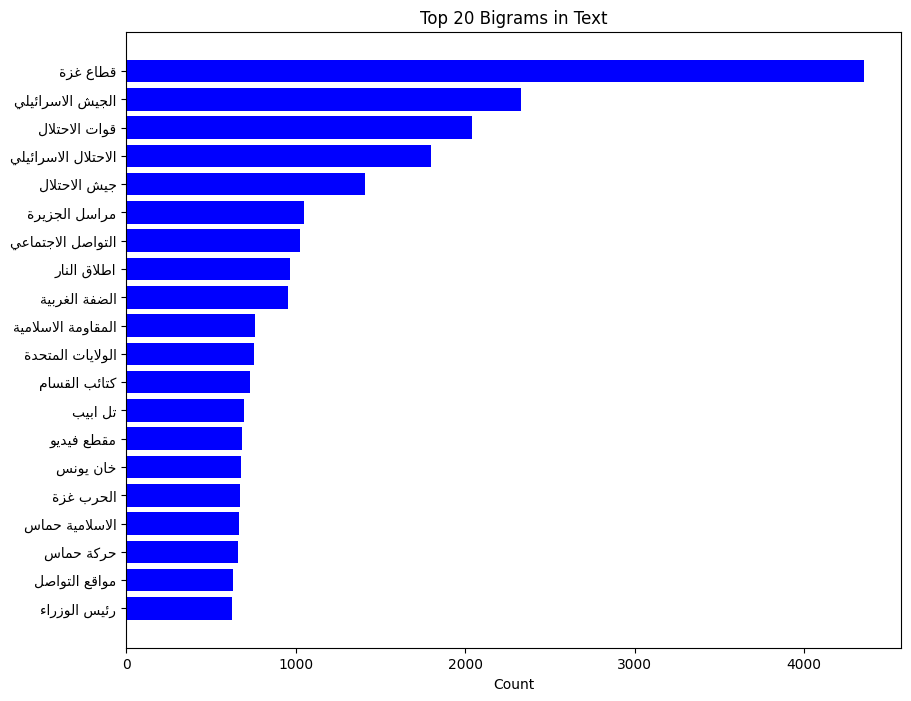

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(df_bigrams['bigram'], df_bigrams['count'], color='blue')
plt.xlabel('Count')
plt.title('Top 20 Bigrams in Text')
plt.gca().invert_yaxis()
plt.show()

## **→ Top 20 Bigrams in Named Entities**

In [ ]:
def extract_ner(full_text, no_ner_text):
    full_text_reshaped = get_display(arabic_reshaper.reshape(full_text))
    no_ner_text_reshaped = get_display(arabic_reshaper.reshape(no_ner_text))

    full_words = full_text_reshaped.split()
    no_ner_words = no_ner_text_reshaped.split()
    ner_words = [word for word in full_words if word not in no_ner_words]
    return ' '.join(ner_words)

NERremoved['NERs'] = NERremoved.apply(lambda row: extract_ner(row['full_news_no_stopwords'], row['full_news_no_ner']), axis=1)


In [ ]:
common_ner_bigrams = get_top_n_bigram(NERremoved['NERs'], 20)

df_ner_bigrams = pd.DataFrame(common_ner_bigrams, columns=['bigram', 'count'])

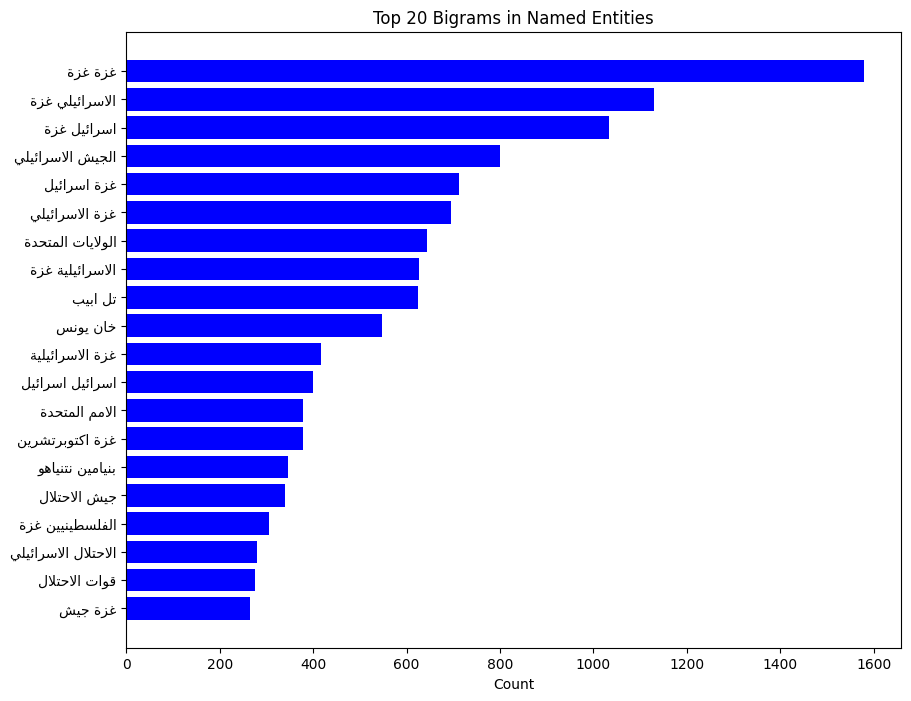

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(df_ner_bigrams['bigram'], df_ner_bigrams['count'], color='blue')
plt.xlabel('Count')
plt.title('Top 20 Bigrams in Named Entities')
plt.gca().invert_yaxis()
plt.show()

## **→ Top 20 Unigrams in Fake News**

In [ ]:
NERremoved['full_news_no_ner'] = NERremoved['full_news_no_ner'].apply(reshape_arabic)

df_label_0 = NERremoved[NERremoved['Label'] == 0]
df_label_1 = NERremoved[NERremoved['Label'] == 1]

In [ ]:
def get_top_n_unigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:

common_fake_unigrams = get_top_n_unigram(df_label_0['full_news_no_ner'], 20)

df_fake_unigrams = pd.DataFrame(common_fake_unigrams, columns=['unigram', 'count'])

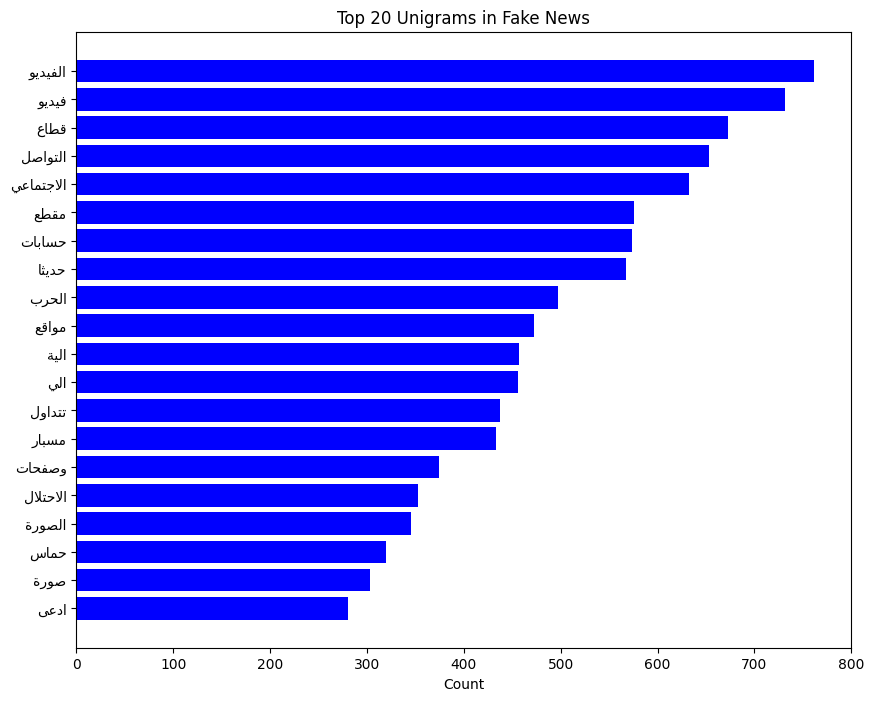

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(df_fake_unigrams['unigram'], df_fake_unigrams['count'], color='blue')
plt.xlabel('Count')
plt.title('Top 20 Unigrams in Fake News')
plt.gca().invert_yaxis()
plt.show()

## **→ Top 20 Unigrams in Real News**

In [ ]:
#NERremoved['full_news_no_stopwords'] = NERremoved['full_news_no_stopwords'].apply(reshape_arabic)

common_real_unigrams = get_top_n_unigram(df_label_1['full_news_no_stopwords'], 20)

df_real_unigrams = pd.DataFrame(common_real_unigrams, columns=['unigram', 'count'])

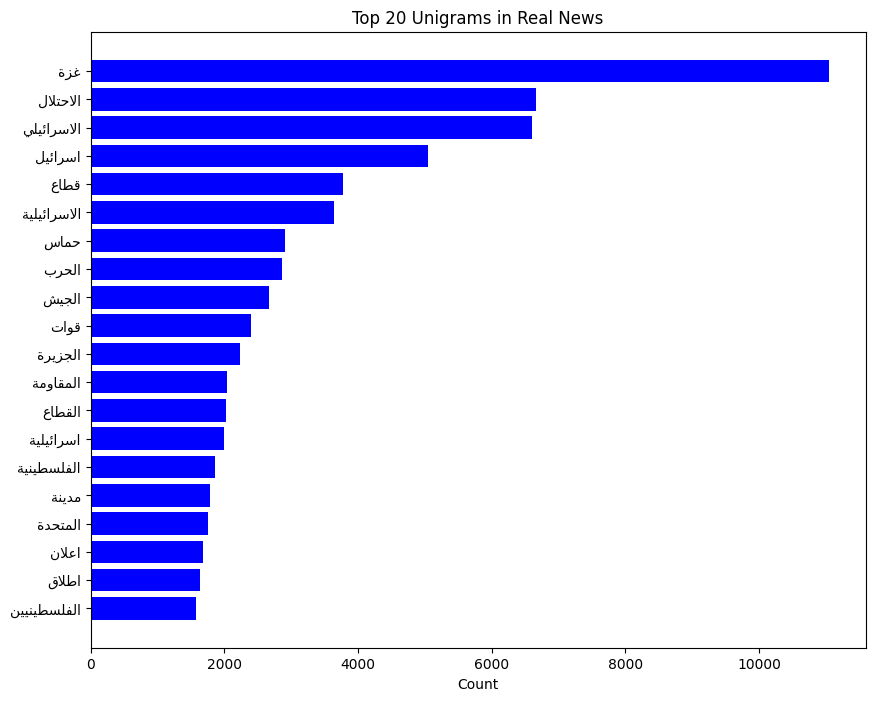

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(df_real_unigrams['unigram'], df_real_unigrams['count'], color='blue')
plt.xlabel('Count')
plt.title('Top 20 Unigrams in Real News')
plt.gca().invert_yaxis()
plt.show()

# **5. Feature Extraction: TF-IDF**

##  **Feature Extraction: TF-IDF (Term Frequency–Inverse Document Frequency)**

In natural language processing (NLP), raw text must be converted into a numerical format before feeding it into machine learning models. One of the most commonly used techniques for this transformation is **TF-IDF**.


---

###  **Why TF-IDF?**

- Helps identify **important words** in a document.
- Filters out **common but less informative words**.
- Produces a **sparse numerical representation** suitable for training machine learning models.

---

###  **Use in Our Project**

In our fake news classification task:

- We used `TfidfVectorizer` from `scikit-learn` to convert Arabic news articles into TF-IDF vectors.
- This allowed the model to learn patterns based on **word importance**, not just frequency.

---

###  **Example**

If the word **"غزة"** appears frequently in one article but not in others, it will have a **high TF-IDF score** in that article — indicating its relevance.

---


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(processedDataLemma['full_news_lemma_clean'].astype(str))

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())


In [ ]:
tfidf_df.head(3)

,آب,آخر,آل,آلة,آمن,آن,آنذاك,آنس,آوى,أب,...,يوليوتموز,يوم,يومي,يون,يونس,يوني,يونيوحزيان,يونيوحزيران,يين,١٤
0,0.0,0.046916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.053399,0.039006,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.038795,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.055778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# (Additional) Top words for each new
top_words_per_doc = tfidf_df.apply(lambda row: row.sort_values(ascending=False).head(3).index.tolist(), axis=1)
processedDataLemma['Top words'] = top_words_per_doc
print(processedDataLemma[['full_news_lemma_clean', 'Top words']].tail(10))


                                  full_news_lemma_clean              Top words
5341  حرب مباشر قسام بث مشهد جديد ل معركة و حراك متس...    [حراك, جديد, متفرق]
5342  الحيثيات متعلق ب مقطع فيديو أظهر نازح اهتفى ؟ ...     [مشهد, احتلال, هو]
5343  الفيديو اشتباك قديم نشر حساب ب عربي موقع ، أمس...  [عربي, الفيديو, مسعف]
5344  الفيديو قديم ل مقتل قناص إسرائيلي تداول حساب و...     [قناص, مقتل, ادعى]
5345  توسع مداهمة هو و اقتحم محور اقتحم إسرائيلي مدي...     [داهم, هو, اقتحام]
5346  حرب مباشر مقاومة تكبد احتلال خسارة كبير و خلاف...     [تكبد, خلاف, أوقع]
5347  تصريح قديم ل مقتل اشتباك حرب جاري تداول حساب و...   [مقتل, تحدث, اشتباك]
5348  الفيديو هدد قديم حرب تداول صفحة و حساب موقعي ت...        [هدد, حد, حديث]
5349  دعم قطعة دعم منظمة دولي نشر تقرير دقيق تقاطع ر...    [منظمة, مراقبة, هو]
5350  لصر خريطة و مصدر مفتوح مساعدة معرفة حي و مبنى ...    [ضرر, خريطة, متضرر]


# **6. Modeling and Evaluation**

## **→ BERT**

In [ ]:
!pip install transformers datasets arabert nltk scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 9.7 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=0ee136a52d4c276894e0938a9ae9190f9111773fe10a32054fc65c3dc590f276
  Stored in directory: /root/.cache/pip/wheels/94/08/b4/78657b1541bb704b088317b52429ee4016d9888fe47dbb130f
Successfully built emoji


In [ ]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import torch
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/processedDataLemma.csv")[['full_news_lemma_clean', 'Label']].dropna()
df.rename(columns={"full_news_lemma_clean": "text", "Label": "label"}, inplace=True)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

In [ ]:
model_name = "asafaya/bert-mini-arabic"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(["text", "__index_level_0__"])
test_dataset = test_dataset.remove_columns(["text", "__index_level_0__"])

train_dataset.set_format("torch")
test_dataset.set_format("torch")


Map:   0%|          | 0/4280 [00:00<?, ? examples/s]

Map:   0%|          | 0/1071 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-mini-arabic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="steps",
    save_steps=20,
    per_device_train_batch_size=16,
  #  per_device_eval_batch_size=16,
    num_train_epochs=2,
    learning_rate=2e-5,
    logging_steps=50,
    fp16=True,
    disable_tqdm=False,
    report_to="none"
  #  weight_decay=0.01,
  #  logging_dir='./logs',
   # load_best_model_at_end=False
)


In [ ]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss
import torch

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")


        class_weights = torch.tensor([2.7, 1.0]).to(model.device)
        loss_fct = CrossEntropyLoss(weight=class_weights)

        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-27-439960948.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [ ]:
trainer.train()


Step,Training Loss
50,0.258100
100,0.290300
150,0.248000
200,0.276500
250,0.227500
300,0.225500
350,0.259700
400,0.262200
450,0.222500
500,0.183600


TrainOutput(global_step=536, training_loss=0.2477025825585892, metrics={'train_runtime': 1223.3663, 'train_samples_per_second': 6.997, 'train_steps_per_second': 0.438, 'total_flos': 42414097121280.0, 'train_loss': 0.2477025825585892, 'epoch': 2.0})

In [ ]:
metrics = trainer.evaluate()
print("Evaluation metrics:", metrics)

Evaluation metrics: {'eval_loss': 0.34874895215034485, 'eval_accuracy': 0.8758169934640523, 'eval_f1': 0.9106783075889859, 'eval_runtime': 49.1902, 'eval_samples_per_second': 21.773, 'eval_steps_per_second': 2.724, 'epoch': 2.0}


In [ ]:
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

              precision    recall  f1-score   support

        Fake       0.71      0.90      0.80       288
        Real       0.96      0.87      0.91       783

    accuracy                           0.88      1071
   macro avg       0.84      0.88      0.85      1071
weighted avg       0.89      0.88      0.88      1071



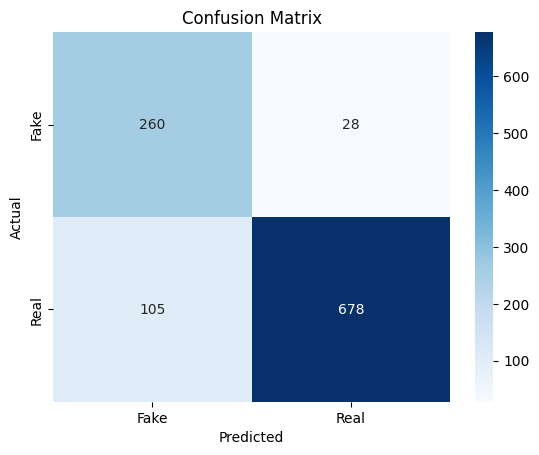

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## **→ Logistic Regression**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/processedDataLemma.csv")[['full_news_lemma_clean', 'Label']].dropna()
df.rename(columns={"full_news_lemma_clean": "text", "Label": "label"}, inplace=True)

In [ ]:
X = df['text']
Y = df['label']

In [ ]:
# converting the textual data to numerical data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
vectorizer.fit(X)

X = vectorizer.transform(X)

In [ ]:
#Splitting the dataset to training & test data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

Accuracy score of the training data :  0.9109813084112149
Accuracy score of the test data :  0.8711484593837535


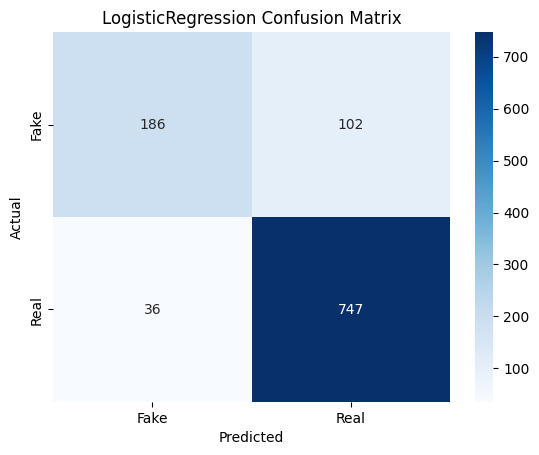

              precision    recall  f1-score   support

        Fake       0.84      0.65      0.73       288
        Real       0.88      0.95      0.92       783

    accuracy                           0.87      1071
   macro avg       0.86      0.80      0.82      1071
weighted avg       0.87      0.87      0.87      1071



In [ ]:

model = LogisticRegression()
model.fit(X_train, Y_train)

# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy)

# accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

lr_probs = model.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(Y_test, X_test_prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],   # 0 = Fake, 1 = Real
            yticklabels=['Fake', 'Real'])   # نفس الترتيب
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LogisticRegression Confusion Matrix')
plt.show()

# Classification report
print(classification_report(Y_test, X_test_prediction, target_names=["Fake", "Real"]))

pickle.dump(model, open("LogisticRegression_model.pkl", "wb"))


## **→ SVM**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

Accuracy score of the training data :  0.9654205607476636
Accuracy score of the test data :  0.8832866479925303


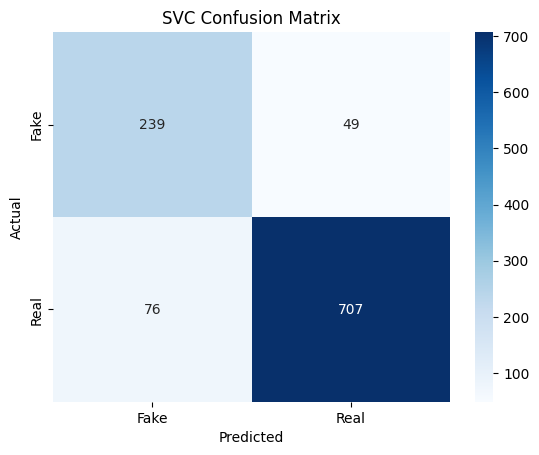

              precision    recall  f1-score   support

        Fake       0.76      0.83      0.79       288
        Real       0.94      0.90      0.92       783

    accuracy                           0.88      1071
   macro avg       0.85      0.87      0.86      1071
weighted avg       0.89      0.88      0.88      1071



In [ ]:

model = SVC(kernel='linear', probability=True, class_weight='balanced')
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
svc_probs = model.predict_proba(X_test)[:, 1]

# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)
print('Accuracy score of the training data : ', training_data_accuracy)

# accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)
print('Accuracy score of the test data : ', test_data_accuracy)

# (Confusion Matrix)
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVC Confusion Matrix')
plt.show()


print(classification_report(Y_test, Y_pred, target_names=["Fake", "Real"]))


pickle.dump(model, open("svm_model.pkl", "wb"))
pickle.dump(vectorizer, open("vectorizer.pkl", "wb"))


## **→ Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

Accuracy score of the training data :  0.9992990654205608
Accuracy score of the test data :  0.8776844070961718


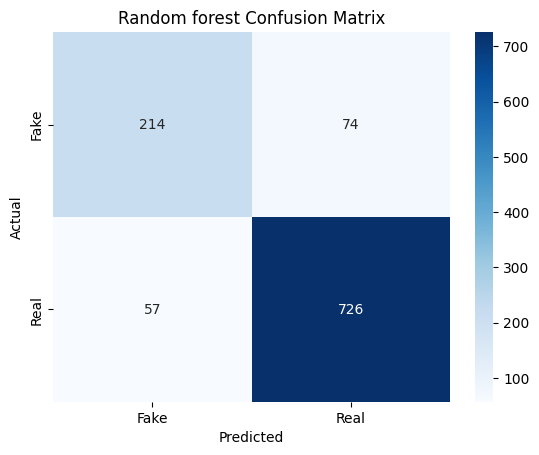

              precision    recall  f1-score   support

        Fake       0.79      0.74      0.77       288
        Real       0.91      0.93      0.92       783

    accuracy                           0.88      1071
   macro avg       0.85      0.84      0.84      1071
weighted avg       0.88      0.88      0.88      1071



In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, Y_train)
rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# accuracy score on the training data
X_train_prediction = rf_model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)
print('Accuracy score of the training data : ', training_data_accuracy)

# accuracy score on the test data
X_test_prediction = rf_model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)
print('Accuracy score of the test data : ', test_data_accuracy)



cm = confusion_matrix(Y_test, X_test_prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Random forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(Y_test, X_test_prediction, target_names=["Fake", "Real"]))


In [ ]:
pickle.dump(model, open("rf_model.pkl", "wb"))

## **→ XGBoost**

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    scale_pos_weight=2,  # Handeling Imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, Y_train)

y_pred = xgb_model.predict(X_test)

xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# accuracy score on the training data
X_train_prediction = xgb_model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)
print('Accuracy score of the training data : ', training_data_accuracy)

# accuracy score on the test data
X_test_prediction = xgb_model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)
print('Accuracy score of the test data : ', test_data_accuracy)


cm = confusion_matrix(Y_test, X_test_prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(Y_test, X_test_prediction, target_names=["Fake", "Real"]))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:25:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
pickle.dump(model, open("xgb_model.pkl", "wb"))

## **Model Performance Comparison using ROC and Precision-Recall Curves**

###  **ROC Curve (Receiver Operating Characteristic)**



The ROC curve illustrates the trade-off between:

- **True Positive Rate (Sensitivity)** on the Y-axis  
- **False Positive Rate** on the X-axis

The closer the curve is to the top-left corner, the better the model is at distinguishing between the two classes.

#### AUC (Area Under the Curve) Results:

| Model                | AUC (ROC) |
|----------------------|-----------|
| SVC                  | 0.95      |
| Random Forest        | 0.94      |
| Logistic Regression  | 0.94      |
| XGBoost              | 0.95      |

 **Conclusion:** All models show strong classification performance, with SVC and XGBoost slightly outperforming the others.

---


### **Precision-Recall Curve**





This curve shows the trade-off between:

- **Recall** (on the X-axis)  
- **Precision** (on the Y-axis)

Precision-Recall curves are especially useful in cases of **class imbalance**.

#### Observations:

- All models start with very high precision.
- As recall increases, precision gradually drops — which is expected since capturing more positives often increases false positives.

**Conclusion:** All models have very similar PR curves, with a slight edge for XGBoost and SVC in maintaining better balance between precision and recall.

---

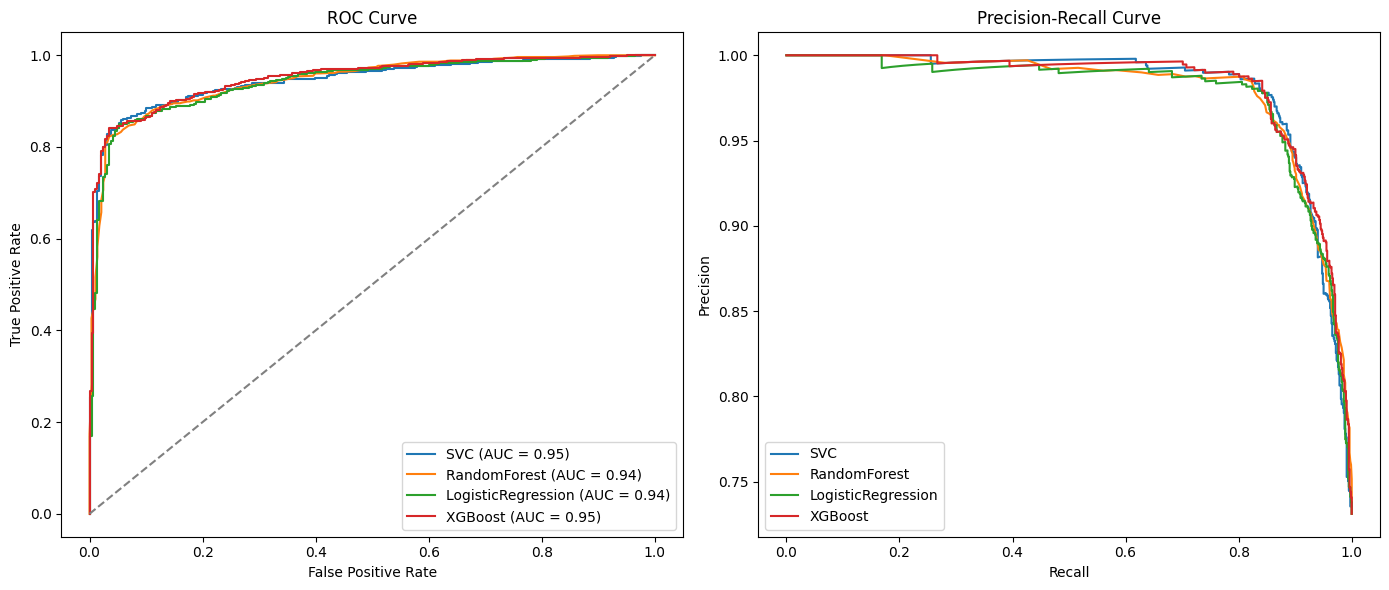

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_curves(y_true, probs_svc, probs_rf, probs_lr, probs_xgb):
    fpr_svc, tpr_svc, _ = roc_curve(y_true, probs_svc)
    fpr_rf, tpr_rf, _ = roc_curve(y_true, probs_rf)
    fpr_lr, tpr_lr, _ = roc_curve(y_true, probs_lr)
    fpr_xgb, tpr_xgb, _ = roc_curve(y_true, probs_xgb)

    plt.figure(figsize=(14, 6))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr_svc, tpr_svc, label=f'SVC (AUC = {auc(fpr_svc, tpr_svc):.2f})')
    plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC = {auc(fpr_rf, tpr_rf):.2f})')
    plt.plot(fpr_lr, tpr_lr, label=f'LogisticRegression (AUC = {auc(fpr_lr, tpr_lr):.2f})')
    plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc(fpr_xgb, tpr_xgb):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    pr_svc, rc_svc, _ = precision_recall_curve(y_true, probs_svc)
    pr_rf, rc_rf, _ = precision_recall_curve(y_true, probs_rf)
    pr_lr, rc_lr, _ = precision_recall_curve(y_true, probs_lr)
    pr_xgb, rc_xgb, _ = precision_recall_curve(y_true, probs_xgb)
    plt.plot(rc_svc, pr_svc, label='SVC')
    plt.plot(rc_rf, pr_rf, label='RandomForest')
    plt.plot(rc_lr, pr_lr, label='LogisticRegression')
    plt.plot(rc_xgb, pr_xgb, label='XGBoost')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_curves(Y_test, svc_probs, rf_probs, lr_probs,xgb_probs)


## **Model Evaluation on Unseen Data**
In this section, we test the best trained model on a separate test text that was not used during training or validation. This step helps us assess the generalization performance of each model on new, real-world-like data.

In [ ]:
import re
import requests

url = "https://raw.githubusercontent.com/mohataher/arabic-stop-words/master/list.txt"
response = requests.get(url)
arabic_stopwords = set(response.text.splitlines())

def clean_arabic_text(text):
    if not isinstance(text, str):
        return ""

    #  HTML tag removal
    text = re.sub(r'http\S+|www.\S+|pic\.twitter\.com/\S+', '', text)
    text = re.sub(r'<.*?>', '', text)

      #  Emoji removal
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    #  diacritics removal
    text = re.sub(r'[\u064B-\u0652]', '', text)

    #  characters normalization
    text = re.sub(r'[إأآا]', 'ا', text)

    #  special characters removal
    text = re.sub(r'[ـ،؛؟!:\.\,\(\)\[\]\{\}"\'«»\-_~…]', '', text)

    # keep Arabic latters only
    lines = text.split('\n')
    cleaned_lines = []
    for line in lines:
        if re.fullmatch(r'[^\u0600-\u06FF]+', line.strip()):
            continue
        line = re.sub(r'[^\u0600-\u06FF\s]', '', line)
        if line.strip():
            cleaned_lines.append(line.strip())

    clean_text = '\n'.join(cleaned_lines)

    # stop words removal
    clean_words = [word for word in clean_text.split() if word not in arabic_stopwords]
    final_text = ' '.join(clean_words)
    return final_text

In [ ]:
from IPython.display import display, HTML

def predict_news(text):
    cleaned_text = clean_arabic_text(text)
    vector = vectorizer.transform([text])
    prediction = model.predict(vector)[0]
    probabilities = model.predict_proba(vector)[0]

    confidence = round(probabilities[prediction] * 100, 2)
    label = "Real News" if prediction == 1 else "Fake News"

    return label, confidence


def display_prediction(text):
    label, confidence = predict_news(text)
    color = "#28a745" if label == "Real News" else "#dc3545"  # أخضر أو أحمر
    comment = "✅ يبدو أن الخبر حقيقي." if label == "Real News" else "⚠️ هذا الخبر يبدو زائفًا أو غير موثق."

    html_output = f"""
    <div style="border:1px solid #ccc; border-radius:8px; padding:15px; margin-bottom:20px; font-family:'Cairo', sans-serif">
        <p><strong>📝 النص:</strong><br>{text}</p>
        <p><strong>📌 التصنيف:</strong> <span style="color:{color}; font-weight:bold">{label}</span></p>
        <p><strong>📊 نسبة الثقة:</strong> {confidence}%</p>
        <p>{comment}</p>
    </div>
    """
    display(HTML(html_output))


In [ ]:
import pickle

model = pickle.load(open("xgb_model.pkl", "rb"))
vectorizer = pickle.load(open("vectorizer.pkl", "rb"))


texts = ["""بادني مستوى إطلاق تقرير فلسطيني أظهر تراجع مؤشرات اقتصادية واجتماعية في الضفة الغربية وقطاع غزة. نقلت مصادر محلية عن دراسة حديثة أن معدلات البطالة والفقر وصلت إلى مستويات غير مسبوقة منذ سنوات، مدفوعة بتأثيرات الحصار وقيود التنقل.

وكشف التقرير أن الأوضاع الأمنية المتقلبة وتدهور البنية التحتية زادت من معاناة السكان، ما أثار قلق واسع بين المسؤولين الفلسطينيين والمجتمع المدني. وعبّر مسؤول رفيع عن استيائه من تدهور الخدمات الأساسية، قائلاً إن الوضع الراهن “غير مقبول ويتطلب تدخل عاجل”.

وأشار التقرير إلى أن الشباب الفلسطيني يشكلون أكبر فئة متضررة، حيث أن فرص التعليم والعمل تراجعت بشكل ملحوظ. وذكر تقرير محلي أن ارتفاع أسعار السلع والخدمات يضغط على الأسر الفقيرة، مما زاد من حجم الاحتجاجات الشعبية في المدن الفلسطينية.

ورغم المحاولات الدولية لتقديم الدعم، ما زالت التحديات كثيرة، وأكدت منظمات حقوق الإنسان ضرورة تعزيز الجهود لرفع الحصار وتحقيق استقرار دائم. واستقر معدل قبول السكان للأوضاع الحالية عند مستويات منخفضة، ما يعكس حالة الإحباط العام بين المواطنين.""",


         """الادعاء بخصوص تدمير مساعدات من شركات تدعم إسرائيل بدون إثبات أو مصدر موثوق.""",


         """الفيديو اشتباك مقاومة تداول حساب و صفحة موقع تواصل اجتماعي ، قليل ، مقطع فيديو أدعى اشتباك عنيف مقاومة مستوطنة غلاف عملية طوفان أقصىمما زاد من حجم الاحتجاجات الشعبية

"""]

for t in texts:
    display_prediction(t)
